In [1]:
#!L
backend = 'Colab'
# Yandex Cloud is temporary unavailable

if backend == 'Colab':
    !pip install lpips
    !git clone https://github.com/yandexdataschool/deep_vision_and_graphics.git
    !sudo apt install -y ninja-build
    %cd /content/deep_vision_and_graphics/week09-gans


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'deep_vision_and_graphics' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ninja-build is already the newest version (1.8.2-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
/content/deep_vision_and_graphics/week09-gans


In [2]:
!wget https://www.dropbox.com/s/2kpsomtla61gjrn/pretrained.tar
!tar -xvf pretrained.tar

import sys
sys.path.append('/content/deep_vision_and_graphics/week09-gans')

--2022-11-06 19:59:08--  https://www.dropbox.com/s/2kpsomtla61gjrn/pretrained.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/2kpsomtla61gjrn/pretrained.tar [following]
--2022-11-06 19:59:08--  https://www.dropbox.com/s/raw/2kpsomtla61gjrn/pretrained.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6762eb6dcf6a6ea5e3b8c870f1.dl.dropboxusercontent.com/cd/0/inline/BwSH5FreZjmaq0wJFdaxOtJLJxNmYLwBkbDmZd8yN8Aue8qTpK_bTD-WUPO6C3FwGgjW03IoIrCrOok_Z_MvcaD5NT3WW9VWPpRuTCirRD5KbVzC5CPE-sONPeT8Ey4ApWn4_BwIBkw4CRNoVXOgWyrwe0II0SwfxoaI--KisYW25A/file# [following]
--2022-11-06 19:59:08--  https://uc6762eb6dcf6a6ea5e3b8c870f1.dl.dropboxusercontent.com/cd/0/inline/BwSH5FreZjmaq0wJFdaxOtJLJxNmYLwBkbDmZd8yN8Aue8qTpK_bTD-WUPO6C3FwGgjW03IoIr

In [3]:
#!L

import os
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt

print (torch.cuda.device_count())
print (torch.__version__)

import torchvision
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from tqdm.auto import tqdm, trange
from PIL import Image

from gans.gan_load import make_stylegan2


def to_image(tensor, adaptive=False):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    if adaptive:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    else:
        tensor = ((tensor + 1) / 2).clamp(0, 1)

    return ToPILImage()((255 * tensor.cpu().detach()).to(torch.uint8))


def to_image_grid(tensor, adaptive=False, **kwargs):
    return to_image(make_grid(tensor, **kwargs), adaptive)

1
1.12.1+cu113


## Style Gan

<a href="https://drive.google.com/file/d/1v-HkF3Ehrpon7wVIx4r5DLcko_U_V6Lt/view">Video</a>.

The Style Generative Adversarial Network, or StyleGAN for short, is an extension to the GAN architecture that proposes large changes to the generator model, including the use of a mapping network to map points in latent space to an intermediate latent space $W$, the use of the intermediate latent space to control style at each point in the generator model, and the introduction to noise as a source of variation at each point in the generator model.

Generating images with conventional GANs, like pixel array generation, had one drawback: it was difficult to control the quality of the images as a whole.

Style GAN thinks of an images as a collection of styles, where each style controls the effects in particular scale.

Model no longer takes a point from the latent space as input. Standalone mapping network is used that takes a randomly sampled point from the latent space as input and generates a style vector.

**Coarse styles**: pose, hair, face shapes

**Middle styles**: face features, eyes

**Fine styles**: color scheme



# Embedding spaces in the Style Gan model:

1) Z, initial noise

2) W, is the intermediate latent space after the fully connected mapping, style embedding (size 512)

3) W+, concatenated embeding (size 18*512).
Embedding in the early stages doesn’t seem to convey sufficient information to the generator about the given image. To solve this, the authors propose W+, extended latent space.

In [4]:
from IPython.display import Image
  
# get the image
Image(url="https://machinelearningmastery.com/wp-content/uploads/2019/06/Summary-of-the-StyleGAN-Generator-Model-Architecture.png", width=600, height=600)

In [10]:
a = torch.load('pretrained/stylegan2-ffhq-config-f.pt')

In [12]:
a.keys()

dict_keys(['g_ema', 'latent_avg', 'g', 'd'])

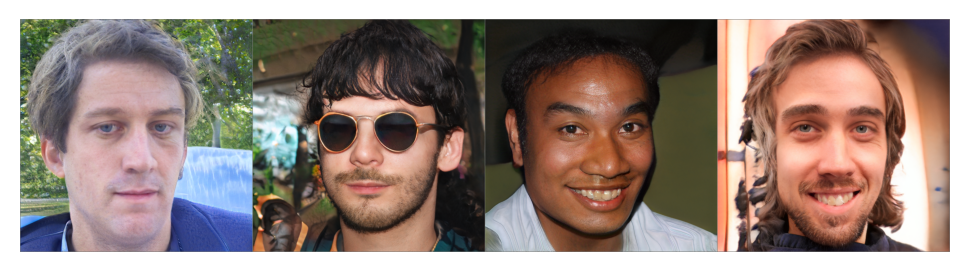

In [5]:
#!L
G = make_stylegan2(resolution=1024,
                   weights='pretrained/stylegan2-ffhq-config-f.pt', target_key='g').eval() ## pre-trained weights from initial model from initial paper


with torch.no_grad():
    z = torch.randn([4, 512]).cuda()
    w_mean = G.style_gan2.mean_latent(256)
    imgs = G(z)

plt.figure(dpi=200)
plt.axis('off')
plt.imshow(to_image_grid(imgs, nrow=6))

# Naive inversions

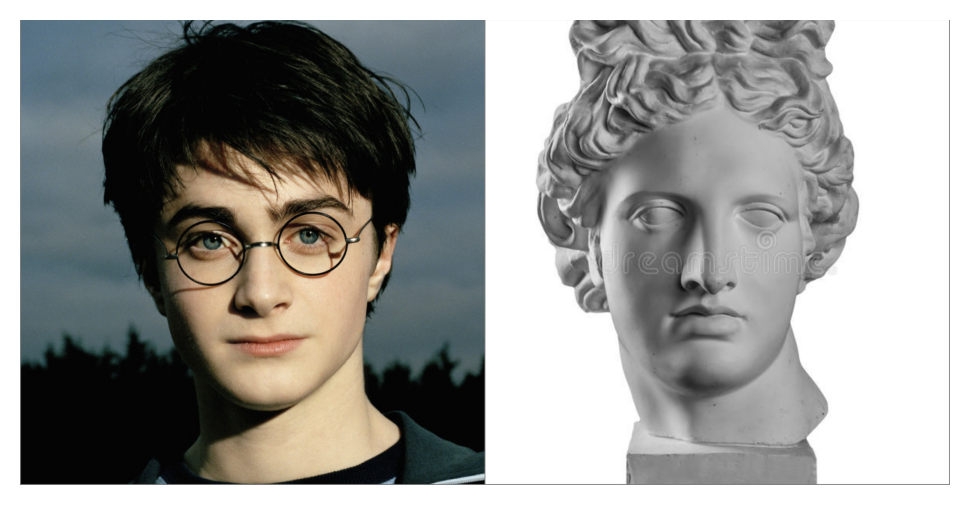

In [6]:
#!L
# download image
import requests
from io import BytesIO
from torchvision import transforms
from PIL import Image

zoom = 1.


def portrait_crop(img, h_percent, w_percent):
    w, h = img.size
    w_offset = int(0.5 * (1 - w_percent) * w)
    return img.crop([w_offset, 0, w - w_offset, int(h_percent * h)])


def load_image(img_url, zoom=1.0, w=1.0, h=1.0):
    crop = lambda x: portrait_crop(x, w, h)

    normalization = transforms.Compose([
        crop,
        transforms.Resize(int(zoom * 1024)),
        transforms.Resize(int(zoom * 1024)),
        transforms.CenterCrop(1024),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ])

    img_data = requests.get(img_url).content
    img = Image.open(BytesIO(img_data))
    return normalization(img).unsqueeze(0).cuda()


imgs = []
for link in [
             'https://fotorelax.ru/wp-content/uploads/2015/08/Daniel-Jacob-Radcliffe_6.jpg',
                'https://i.pinimg.com/736x/26/29/ca/2629ca7ed31a6867965d7f8e7a0c60c6.jpg'
            ]:
    imgs.append(load_image(link))
imgs = torch.cat(imgs)
img = imgs[0][None]


plt.figure(dpi=200)
plt.axis('off')
plt.imshow(to_image_grid(imgs))

Load Lpips library, which count **Perceptual Similarity~(LPIPS)**. 

**LPIPS** essentially computes the similarity between the activations of two image patches for some pre-defined network (Alexnet by default). In addition, model create its own networks based on channels from pre-defined model. A low LPIPS score means that image patches are perceptual similar.

We also load regressor based on ResNet features. The difference between output of the regressor is also loss.

In [43]:
#!L
import lpips
lpips_model = lpips.LPIPS()
lpips_model.cuda().eval()
lpips_dist = lambda x, y: lpips_model(
    F.interpolate(x, 256, mode='bilinear'),
    F.interpolate(y, 256, mode='bilinear'))

# CelebA regressor features extractor
face_fe = torchvision.models.resnet18()
face_fe.fc = nn.Sequential(nn.ReLU(), nn.Linear(512, 512), nn.ReLU())

state_dict = torch.load('pretrained/regressor.pth')['model_state_dict']
state_dict = {name[len('backbone.'):]: val for name, val in state_dict.items() if name.startswith('backbone.')}

face_fe.load_state_dict(state_dict)
face_fe.cuda().eval();

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


In [44]:
#!L
def invert(img, G, latent_init, n_steps=500, lr=0.025,
           l2_loss_scale=0.1, lpips_loss_scale=1.0, id_loss_scale=1.0,
           latent_map=lambda x: x, **g_kwargs):
    latent = nn.Parameter(latent_init.cuda())
    opt = torch.optim.Adam([latent,], lr=lr)

    l2_losses = []
    perceptual_losses = []
    id_losses = []
    losses = []
    for i in trange(n_steps):
        opt.zero_grad()

        reconstruction = G(latent_map(latent), **g_kwargs)
        l2_loss, perceptual_loss, id_loss = [torch.zeros([])] * 3
        if l2_loss_scale > 0.0:
            l2_loss = F.mse_loss(img, reconstruction).mean()
        if lpips_loss_scale > 0.0:
            perceptual_loss = lpips_dist(img, reconstruction).mean()
        if id_loss_scale > 0.0:
            id_loss = F.mse_loss(face_fe(img), face_fe(reconstruction)).mean()

        loss = l2_loss_scale * l2_loss + lpips_loss_scale * perceptual_loss + id_loss_scale * id_loss
        loss.backward()

        l2_losses.append(l2_loss.item())
        perceptual_losses.append(perceptual_loss.item())
        id_losses.append(id_loss.item())
        losses.append(loss.item())

        opt.step()
        if i % 100 == 0:
            print(f'{i}: loss: {np.mean(losses[-100:]): 0.2f}; '
                  f'l2-loss: {np.mean(l2_losses[-100:]): 0.2f}; '
                  f'lpips loss: {np.mean(perceptual_losses[-100:]): 0.2f}; '
                  f'id-loss: {np.mean(id_losses[-100:]): 0.2f}')

    return reconstruction, latent, losses


def show_inversion_result(img, reconstruction, losses=None):
    _, axs = plt.subplots(1, 3, dpi=250)
    for ax in axs[:2]: ax.axis('off')

    axs[0].imshow(to_image_grid(img))
    axs[1].imshow(to_image_grid(reconstruction))
    if losses is not None:
        axs[2].set_aspect(1.0 / np.max(losses) * len(losses))
        axs[2].set_title('Loss')
        axs[2].plot(losses)

In [36]:
img = imgs[1][None]

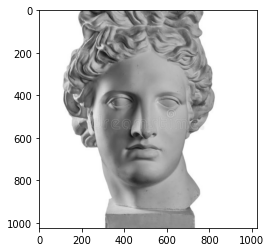

In [37]:
plt.imshow(to_image_grid(img))

  0%|          | 0/100 [00:00<?, ?it/s]

0: loss:  1.07; l2-loss:  2.07; lpips loss:  0.81; id-loss:  0.05


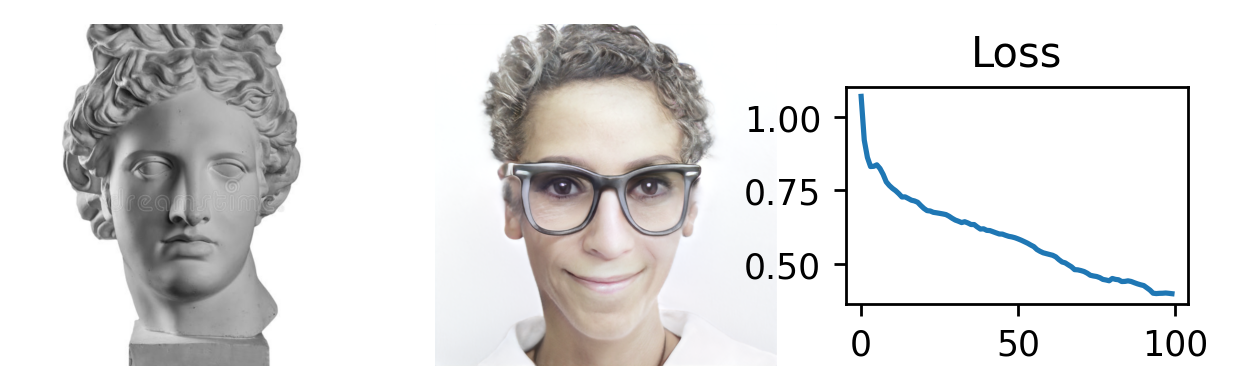

In [45]:
#!L
rec, z, losses = invert(img, G, torch.randn([1, G.dim_z]), n_steps=100,
                        l2_loss_scale=0.1, lpips_loss_scale=1.0, id_loss_scale=1.0)
show_inversion_result(img, rec, losses)

  0%|          | 0/100 [00:00<?, ?it/s]

0: loss:  0.01; l2-loss:  0.00; lpips loss:  0.00; id-loss:  0.01


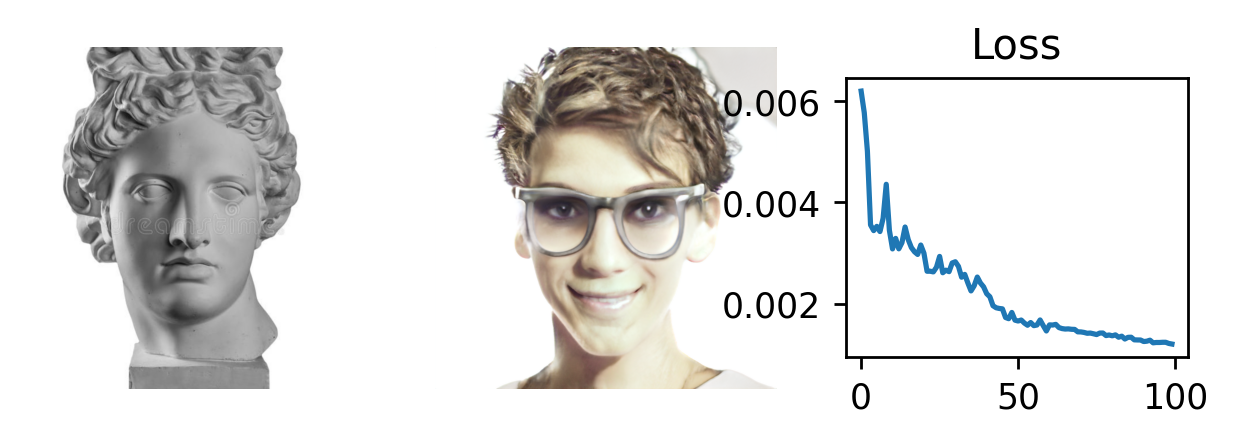

In [46]:
#!L
rec, z, losses = invert(img, G, z, n_steps=100,
                        l2_loss_scale=0.0, lpips_loss_scale=0.0, id_loss_scale=1.0)
show_inversion_result(img, rec, losses)

  0%|          | 0/500 [00:00<?, ?it/s]

0: loss:  0.18; l2-loss:  0.08; lpips loss:  0.17; id-loss:  0.00
100: loss:  0.19; l2-loss:  0.08; lpips loss:  0.18; id-loss:  0.00
200: loss:  0.18; l2-loss:  0.08; lpips loss:  0.17; id-loss:  0.00
300: loss:  0.17; l2-loss:  0.08; lpips loss:  0.16; id-loss:  0.00
400: loss:  0.17; l2-loss:  0.07; lpips loss:  0.16; id-loss:  0.00


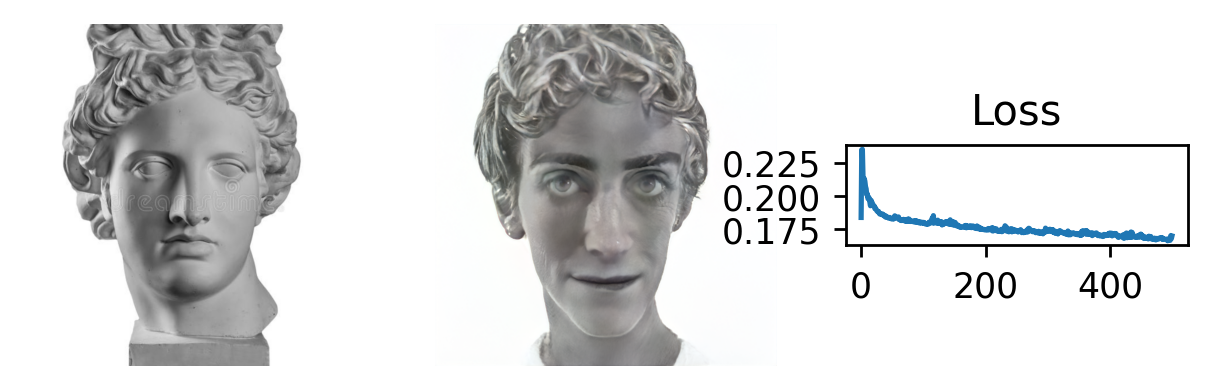

In [47]:
#!L
rec, w, losses = invert(img, G, w_mean, w_space=True, n_steps=500)
show_inversion_result(img, rec, losses)

The **W+ latent space** is a concatenation of 18 different 512-dimensional w vectors for each style of the AdaIn layer in the StyleGAN

In [61]:
a = G.style_gan2.mean_latent(256) # create 256 vectors of self.style_dim dim (512), take it to A layer, mean of all along 0
a.shape

torch.Size([1, 512])

  0%|          | 0/100 [00:00<?, ?it/s]

0: loss:  0.76; l2-loss:  0.96; lpips loss:  0.65; id-loss:  0.02


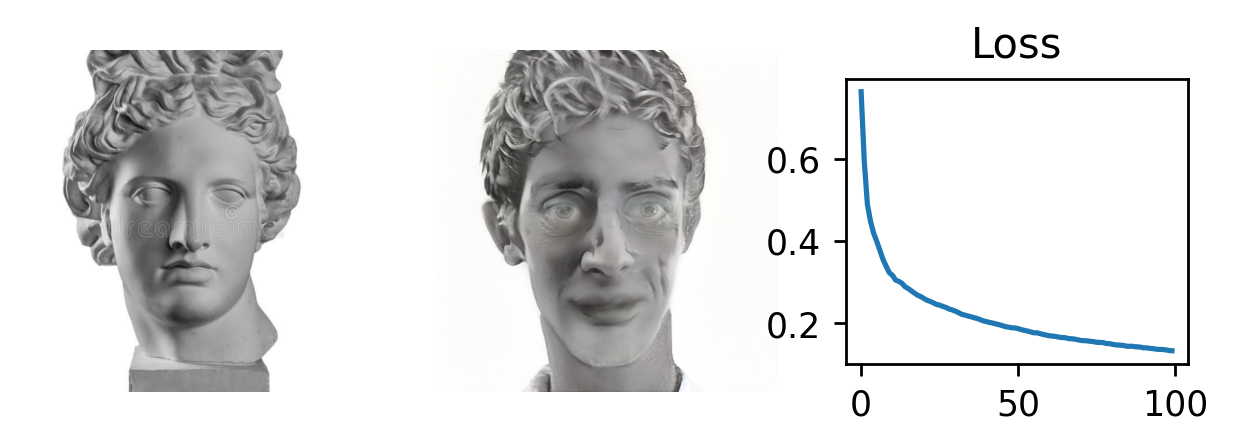

In [48]:
#!L
w_mean = G.style_gan2.mean_latent(64)
rec, w_plus, losses = invert(img, G, w_mean.unsqueeze(1).repeat(1, 18, 1), n_steps=100,
                             latent_map=lambda w_plus: [w_plus], w_space=True)
show_inversion_result(img, rec, losses)

# Pix2Style2Pix

cc: https://github.com/eladrich/pixel2style2pixel

Based on encoder network that directly generates a series of style vectors which are fed into a pretrained StyleGAN generator, forming the extended W+ latent space

In [26]:
!git clone https://github.com/eladrich/pixel2style2pixel
!touch pixel2style2pixel/__init__.py

fatal: destination path 'pixel2style2pixel' already exists and is not an empty directory.


In [27]:
#!L
import sys
sys.path.append('pixel2style2pixel')
from models.encoders.psp_encoders import GradualStyleEncoder
from argparse import Namespace

encoder_chkpt = torch.load('pretrained/psp_ffhq_encode.pt')
encoder = GradualStyleEncoder(50, 'ir_se', opts=Namespace(**encoder_chkpt['opts']))
encoder_state = {name[len('encoder.'):]: val for name, val in encoder_chkpt['state_dict'].items() \
                 if name.startswith('encoder')}

encoder.load_state_dict(encoder_state)
encoder.cuda().eval();
latent_mean = encoder_chkpt['latent_avg'].cuda()

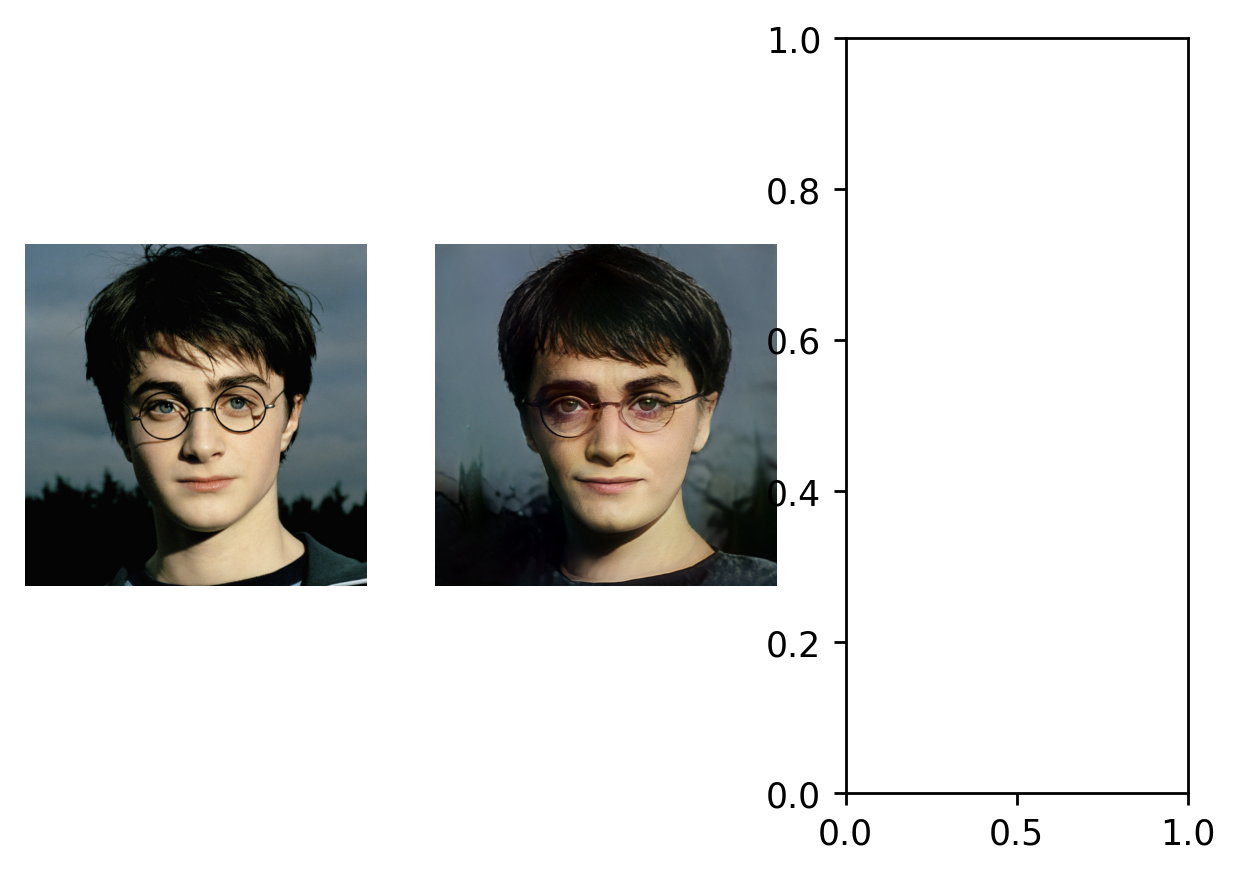

In [28]:
#!L
with torch.no_grad():
    w_inversion = encoder(F.interpolate(img, 256, mode='bilinear')) + latent_mean[None]
    rec = G([w_inversion], w_space=True)
show_inversion_result(img, rec)

### pix2style2pix with optimization

  0%|          | 0/100 [00:00<?, ?it/s]

0: loss:  0.20; l2-loss:  0.06; lpips loss:  0.19; id-loss:  0.00


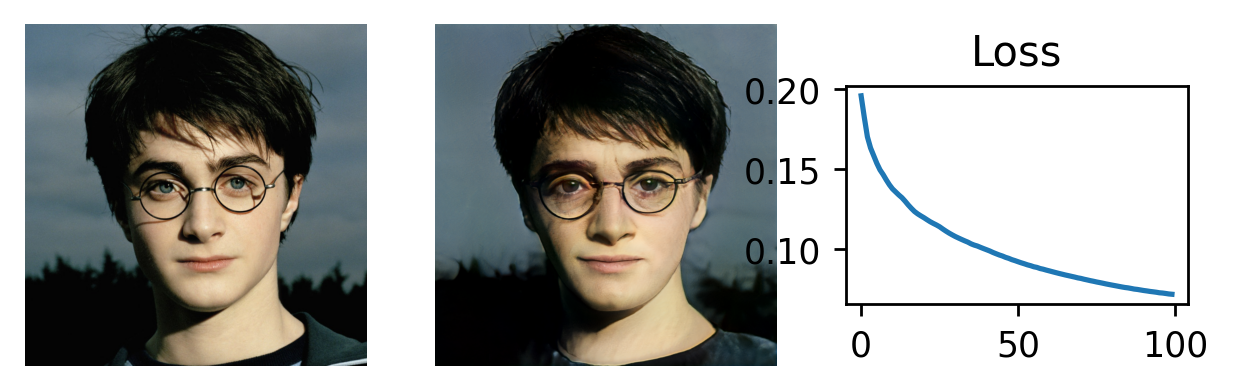

In [29]:
#!L
rec, w_plus, losses = invert(img, G, w_inversion, n_steps=100, lr=0.005,
                             latent_map=lambda w_plus: [w_plus], w_space=True)
show_inversion_result(img, rec, losses)

# CLIP + StyleGAN

cc: https://github.com/openai/CLIP

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. We found CLIP matches the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.

In [13]:
G = make_stylegan2(resolution=1024,
                   weights='pretrained/stylegan2-ffhq-config-f.pt', target_key='g').eval()


In [8]:
!pip3 install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#!L
from CLIP.clip_wrapper import CLIPWrapper
clip = CLIPWrapper().cuda()

/content/deep_vision_and_graphics/week09-gans/CLIP/clip/clip.py:23: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [10]:
#!L
target_text = 'johnny depp'

with torch.no_grad():
    text_embed = clip.text_embed(target_text)

  0%|          | 0/100 [00:00<?, ?it/s]

-0.11859130859375
-0.147216796875
-0.15283203125
-0.1800537109375
-0.236083984375
-0.20849609375
-0.1961669921875
-0.2015380859375
-0.2076416015625
-0.21240234375


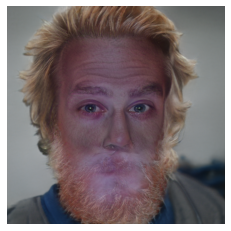

In [11]:
#!L
w_mean = G.style_gan2.mean_latent(64)
w = nn.Parameter(w_mean)
opt = torch.optim.Adam([w,], lr=0.005)


for i in trange(100):
    synth = G(w, w_space=True)
    img_embed = clip.clip_embed(synth)

    loss = -torch.cosine_similarity(img_embed, text_embed)
    loss.backward()
    if i % 10 == 0:
        print(loss.item())
    opt.step()
    
opt.zero_grad()

plt.axis('off')
plt.imshow(to_image(synth))

### add crop augmentations

  0%|          | 0/201 [00:00<?, ?it/s]

0: -20.28 +  0.00
100: -30.00 +  0.88
200: -29.77 +  1.00


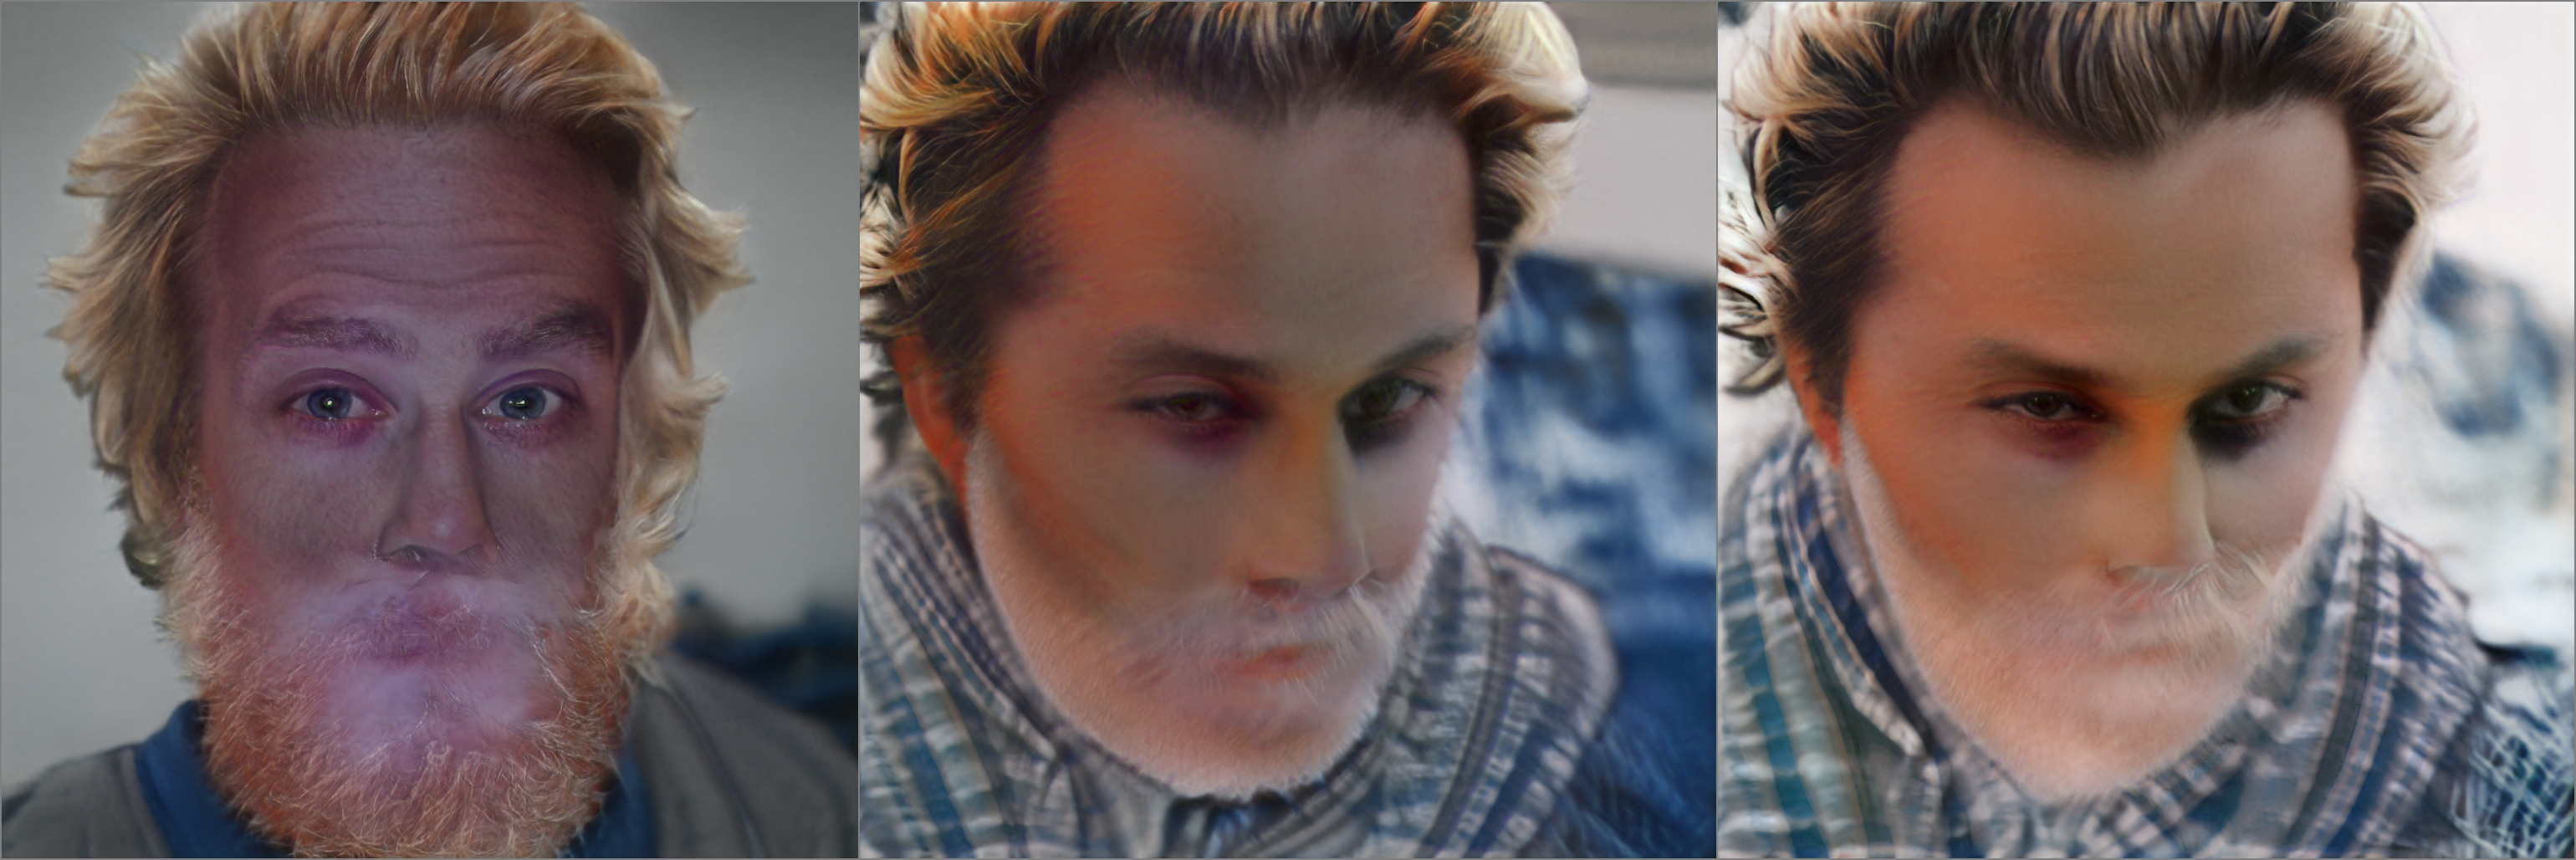

In [12]:
#!L
G = make_stylegan2(resolution=1024,
                   weights='pretrained/stylegan2-ffhq-config-f.pt', target_key='g').eval()


latent = nn.Parameter(w_mean.detach().clone())
opt_latent = torch.optim.Adam([latent,], lr=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt_latent, 0.995)

generated_imgs = []
n_steps = 201
save_every = 100
inversion_space = 'w'


for step in trange(n_steps):
    img = G(latent, w_space=True)
    side_x = img.shape[-1]

    crops = []
    for ch in range(4):
        size = int(side_x * torch.zeros(1,).normal_(mean=0.75, std=0.3).clip(0.5, 0.99))
        offset_x = torch.randint(0, side_x - size, ())
        offset_y = torch.randint(0, side_x - size, ())

        apper = img[:, :, offset_x: offset_x + size, offset_y: offset_y + size]
        apper = F.interpolate(apper, (224, 224), mode='nearest')
        crops.append(apper)

    crops = torch.cat(crops, dim=0)
    crops_embed = clip.clip_embed(crops)
    similarity_loss = -100 * torch.cosine_similarity(text_embed, crops_embed, dim=-1).mean()

    latent_loss = 0.0
    if inversion_space == 'z':
        latent_loss = latent.norm()
    elif inversion_space == 'w':
        latent_loss = (latent - w_mean).norm()
    latent_loss *= 0.1

    # optimize
    opt_latent.zero_grad()

    loss = similarity_loss + latent_loss
    loss.backward(retain_graph=True)

    opt_latent.step()
    scheduler.step()

    if step % save_every == 0:
        generated_imgs.append(img.detach().cpu())
        print(f'{step}: {similarity_loss.item(): 0.2f} + {latent_loss.item(): 0.2f}')

to_image_grid(torch.cat(generated_imgs))